In [529]:
from bs4 import BeautifulSoup
from xml.etree import ElementTree
from collections import defaultdict
import matplotlib.pyplot as plt
import psycopg2
import os
import pandas as pd
import numpy as np

dbname = 'plant_database'
user = 'user'
host = '172.18.0.2'
password = "pass"
port = 5432
db_params = {'dbname':dbname, 'user':user, 'host':host, 'password':password, 'port':port}


dtypes_dict = {'object':'varchar', 'int64':'int', 'int32':'int',\
               'datetime64[ns]':'timestamp', 'float64':'numeric'}


In [522]:
def etree_to_dict(t):
    d = {t.tag: {} if t.attrib else None}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(etree_to_dict, children):
            for k, v in dc.items():
                dd[k].append(v)
        d = {t.tag: {k: v[0] if len(v) == 1 else v
                     for k, v in dd.items()}}
    if t.attrib:
        d[t.tag].update(('@' + k, v)
                        for k, v in t.attrib.items())
    if t.text:
        text = t.text.strip()
        if children or t.attrib:
            if text:
                d[t.tag]['#text'] = text
        else:
            d[t.tag] = text
    return d


def make_sql_req(sql_req):
    try:
        conn = psycopg2.connect(**db_params)
        cursor = conn.cursor()
        cursor.execute(sql_req)
        conn.commit()
        count = cursor.rowcount
        cursor.close()
        conn.close()
    except: pass

        
def create_tab(df, dtypes_dict, table_name):
    dtypes_ = df.dtypes
    dtypes_ = dtypes_.astype(str).map(dtypes_dict).reset_index().values
    sql_req = f'CREATE TABLE {table_name} ('+', '.join([f'"{i[0]}"'+' '+i[1] for i in dtypes_]) + ')'
    make_sql_req(sql_req)


def insert_init_data(df, table_name):
    df = df.fillna('NULL')
    df = df.astype(str)
    cols = '(' + ', '.join([f'"{str(i)}"' for i in df.columns]) + ')'
    vals = ', '.join([', '.join(str(i).split(' ')) for i in df.values])
    vals = vals.replace('[', '(').replace(']', ')')
    vals = vals.replace("'NULL'", 'NULL')
    sql_req = f"INSERT INTO {table_name} {cols} VALUES {vals};"
    make_sql_req(sql_req)


In [523]:
def get_osc_data(path):
    tree = ElementTree.parse(path)
    tree = tree.getroot()
    data_dict = etree_to_dict(tree)
    
    ts_list = data_dict['{http://www.boschrexroth.de/indraworks.textformatter.xsd}root']\
    ['{http://www.boschrexroth.de/indraworks.textformatter.xsd}OscilloscopeData'] \
    ['{http://www.boschrexroth.de/indraworks.textformatter.xsd}Devices'] \
    ['{http://www.boschrexroth.de/indraworks.textformatter.xsd}Device'] \
    ['{http://www.boschrexroth.de/indraworks.textformatter.xsd}Measurements']\
    ['{http://www.boschrexroth.de/indraworks.textformatter.xsd}Measurement']\
    ['{http://www.boschrexroth.de/indraworks.textformatter.xsd}Signals']\
    ['{http://www.boschrexroth.de/indraworks.textformatter.xsd}Signal']

    ts_dict = {}
    name_dict = {'S-0-0047.0.0 Position command value':'pcv',\
                'S-0-0051.0.0 Position feedback value 1':'pfv',\
                'S-0-0040.0.0 Velocity feedback value':'vfv',\
                'P-0-0440.0.0 Actual output current value (absolute value)':'cv'}
    for ts in ts_list:
        ts_dict[name_dict[ts['{http://www.boschrexroth.de/indraworks.textformatter.xsd}Name']]] = \
        {'x':[float(i) for i in ts['{http://www.boschrexroth.de/indraworks.textformatter.xsd}XValue'].split('|')], \
         'y':[float(i) for i in ts['{http://www.boschrexroth.de/indraworks.textformatter.xsd}YValue'].split('|')]}
        
    return ts_dict

In [524]:
files = os.listdir('../files')
tsd = {f:get_osc_data(f'../files/{f}') for f in files}
cols = ['pcv', 'pfv', 'vfv', 'cv']

In [525]:
def get_w_mean(x, mean):
    diff = np.abs(x - mean)
    weights = 1/diff
    mean_weighted = (weights*x).sum()/(weights.sum())
    mean_weighted = (weights*x).sum()/(weights.sum())
    return mean_weighted

def mean_calc(x):
    if len(x)<2: return x.values[0]
    if len(x.unique())<2: return x.values[0]
    mean = np.mean(x)
    mean_weighted = get_w_mean(x, mean)
    mean_weighted = get_w_mean(x, mean_weighted)
    return mean_weighted



df = pd.DataFrame()
for k,v in tsd.items():
    for col in cols:
        
        df_item = v[col]
        df_item = pd.DataFrame(df_item)
        df_item['filename'] = k
        df_item['feature'] = col
        df = df.append(df_item, ignore_index=True)
        
df = df.sort_values(['filename', 'feature', 'x'])
df.index = pd.RangeIndex(len(df))

In [526]:
df = df.merge(df.groupby(['feature', 'x'])['y'].mean().reset_index().rename(columns = {'y':'y_mean'}))

for _ in range(7):
    df['weight'] = 1/((df['y'] - df['y_mean']).abs())
    df.loc[df['weight']==np.inf, 'weight'] = 1_000
    df['y_w'] = df['y']*df['weight'] 
    df = df.merge(df.groupby(['feature', 'x'])['y_w'].sum().reset_index().rename(columns = {'y_w':'y_w_sum'}))
    df = df.merge(df.groupby(['feature', 'x'])['weight'].sum().reset_index().rename(columns = {'weight':'weight_sum'}))
    df['y_mean'] = df['y_w_sum']/df['weight_sum']
    
    df = df.drop(columns = ['weight', 'y_w', 'y_w_sum', 'weight_sum'])
    
df = df.merge(df.groupby(['feature'])['y'].min().reset_index().rename(columns = {'y':'y_min'}))
df = df.merge(df.groupby(['feature'])['y'].max().reset_index().rename(columns = {'y':'y_max'}))

df['deviation'] = (df['y'] - df['y_mean']).abs()/(df['y_max'] - df['y_min'])
df['status'] = 'ok'
df.loc[df['deviation']>0.1, 'status'] = 'anomaly'

In [530]:
create_tab(df, dtypes_dict, 'operational_layer.oscilloscope_data')
insert_init_data(df, 'operational_layer.oscilloscope_data')


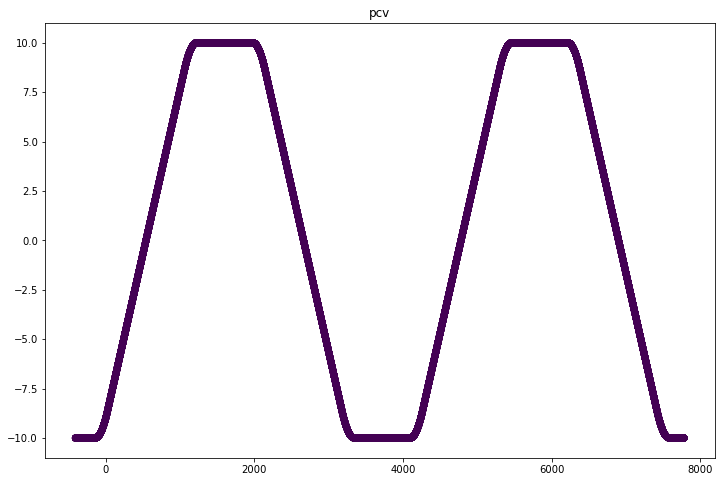

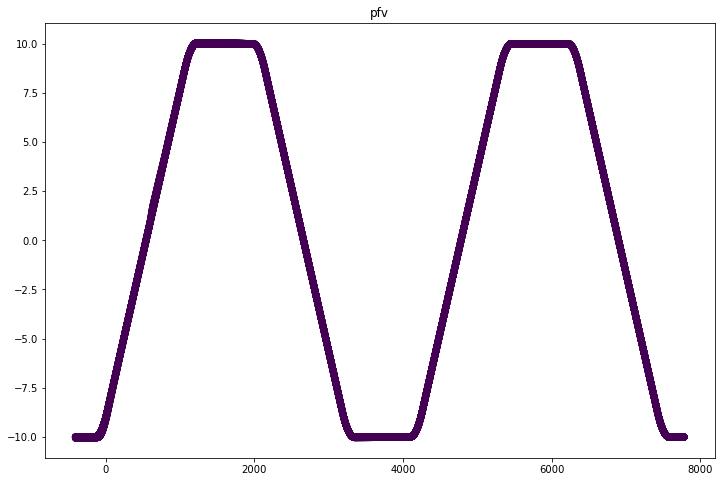

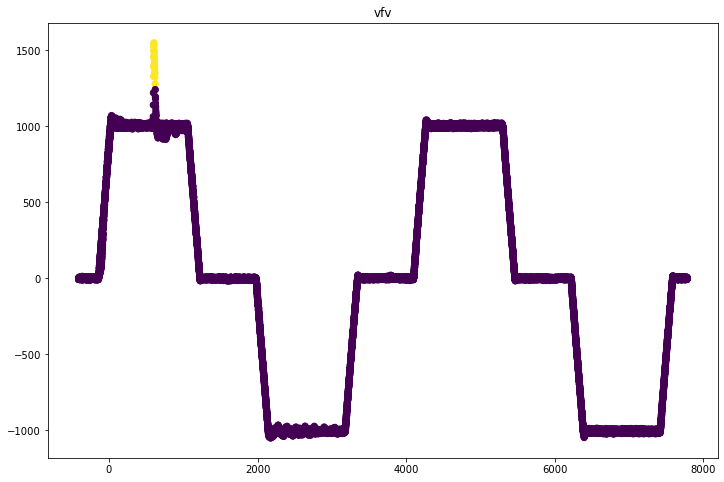

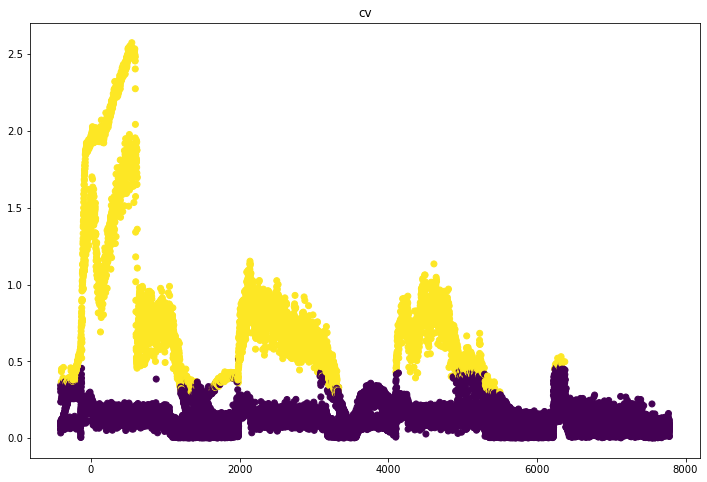

In [535]:
cols = ['pcv', 'pfv', 'vfv', 'cv']
for col in cols[:]:
    plt.figure(figsize = (12, 8))
    dfv = df[df['feature']==col]
    for f in dfv['filename'].unique():
        dfvi = dfv[dfv['filename']==f]
        diff = pd.Series(v[col]['y']).values
        
        plt.scatter(dfvi['x'], dfvi['y'], label=f, c=(dfvi['deviation']>0.1))
    plt.title(col)
    plt.savefig(f'{col}_anomalies.png')

In [533]:
make_sql_req('DROP TABLE operational_layer.oscilloscope_data')